In [1]:
#%load_ext autoreload
#%autoreload 2

# Configuring the Application

First, let’s import the necessary dependencies

- panel for dashboard
- json for reading data, datetime for date and time manipulation
- numpy and pandas for data analysis
- hvplot, matplotlib, and seaborn for data display and plotting

In [2]:
import datetime
import json
import math
from collections import Counter, defaultdict
from pprint import pp

# data analysis
import numpy as np
import pandas as pd

# dashboard
import panel as pn

# plotting
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.figure import Figure
from matplotlib import cm

Next, we’ll import the Panel JavaScript dependencies using `pn.extension(...)`.

The `'ipywidgets'` extension is recommended to use with `Matplotlib` pane in the Panel documentation.

For a visually appealing and responsive user experience, we’ll set the `design` to `"material"` and the `sizing_mode` to `"stretch_width"`:

In [3]:
#pn.extension('ipywidgets', design="material", sizing_mode="stretch_width")
pn.extension('ipywidgets', design="material", sizing_mode='fixed')

# Fetching the Data

The annotation data was generated from the `tensorflow` repository with the following command:
```commandline
time diff-annotate from-repo ...
```
by running `dvc repro` command ("annotate" stage).

-----

The statistics in `'tensorflow.timeline.json'` file were generated with the following command:

```commandline
time diff-gather-stats \
    --annotations-dir='' \
    timeline \
    ...
```
by running `dvc repro` command ("timeline" stage).

The statistics in `'tensorflow.timeline.purpose-to-type.json'` file were generated with the following command:

```commandline
diff-gather-stats \
    --annotations-dir='' \
    timeline \
    --purpose-to-annotation=data \
    --purpose-to-annotation=documentation \
    --purpose-to-annotation=markup \
    --purpose-to-annotation=other \
    --purpose-to-annotation=project \
    --purpose-to-annotation=test \
    ...
```
by running `dvc repro` command ("timeline.putpose-to-type" stage).

In [4]:
TOP_DIR = '../../'
DATASET_DIR = f'{TOP_DIR}data/examples/stats'
JSON_FILE = 'tensorflow.timeline.purpose-to-type.json'

We’ll speed up our application by caching (`@pn.cache`) the data across users

In [5]:
@pn.cache
def get_timeline_data():
    with open(f'{DATASET_DIR}/{JSON_FILE}', mode='r') as json_fp:
        return json.load(json_fp)

In [6]:
timeline_data = get_timeline_data()
type(timeline_data)

dict

There is only one dataset: `'tensorflow'`

In [7]:
timeline_data.keys()

dict_keys(['tensorflow'])

In [8]:
tf_timeline_data = timeline_data['tensorflow']

Create `DataFrame` out of timeline data

In [9]:
tf_timeline_df = pd.DataFrame.from_records(tf_timeline_data)
tf_timeline_df

,bug_id,patch_id,file_names,language:Starlark,type:programming,purpose:project,+:count,+:type.project,+:purpose.project,author.timestamp,...,language:Cython,language:Protocol Buffer,language:MLIR,language:HTML,type:markup,purpose:markup,+:type.markup,+:purpose.markup,-:type.markup,-:purpose.markup
0,yong.tang,cf1429707d68edb22cd861ce900d0ec4600668e5.json,1.0,1.0,1.0,1.0,3.0,3.0,3.0,1.527102e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,yong.tang,66803c1fca4d178d6ba8f4c96073efaed8541d59.json,1.0,NaN,1.0,NaN,22.0,NaN,NaN,1.566144e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,yong.tang,771a8060e8eea386d75ace3d08794f3b967db564.json,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.531462e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,yong.tang,caf1e0e307efe8746de167dcd0f2b226ac7cbea9.json,1.0,NaN,1.0,NaN,8.0,NaN,NaN,1.664984e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,yong.tang,f6940f2195b5f3e017ab5b8618d1a6fd5d6671ac.json,1.0,NaN,1.0,NaN,4.0,NaN,NaN,1.594938e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ezhulenev,46cf49d55bda33fefa7681631f01c7d4c9eafcd6.json,14.0,2.0,12.0,2.0,1711.0,117.0,117.0,1.698380e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3340,ezhulenev,98aa5d0be743aca99992c0e58fc2980b332594bb.json,3.0,NaN,2.0,NaN,10.0,NaN,NaN,1.582264e+09,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3341,ezhulenev,422bd16858138f711c2672cd8a8b98ac07d5a18c.json,4.0,1.0,4.0,1.0,27.0,1.0,1.0,1.717111e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342,ezhulenev,a4e0c1111c3640366a5d7593444a31227a6b2811.json,1.0,NaN,1.0,NaN,7.0,NaN,NaN,1.711592e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploring the Parameter Space

Let’s create some Panel slider widgets to explore the range of parameter values:

## Repository (fake)

In [10]:
repos_widget = pn.widgets.Select(name="repository", value="tensorflow", options=["tensorflow"], disabled=True)

In [11]:
display(repos_widget)

Select(design=<class 'panel.theme.materi..., disabled=True, name='repository', options=['tensorflow'], value='tensorflow')

## Authors

In [12]:
authors = tf_timeline_df['bug_id'].unique()

In [13]:
authors_widget = pn.widgets.Select(name="author", value=authors[0], options=list(authors))

Test that the `authors_widget` works:

In [14]:
display(authors_widget)

Select(design=<class 'panel.theme.materi..., name='author', options=['yong.tang', ...], value='yong.tang')

In [15]:
authors_counts = tf_timeline_df['bug_id'].value_counts().to_dict()
authors_counts

{'ezhulenev': 1896, 'yong.tang': 1448}

In [16]:
authors_radio_box = pn.widgets.RadioBoxGroup(
    name='choose author', value=authors[0], inline=False,
    options={
        f"{author:14s}: {authors_counts[author]:6d} commits": author
        for author in authors_counts.keys()
    }
)

In [17]:
display(authors_radio_box)

RadioBoxGroup(design=<class 'panel.theme.materi..., name='choose author', options={'ezhulenev     :   1896 c...}, value='yong.tang')

## Resample rate

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [18]:
pd.DataFrame.from_records(
    columns=['Alias', 'Description'],
    data=[
        ('B', 'business day frequency'),
        ('C', 'custom business day frequency'),
        ('D', 'calendar day frequency'),
        ('W', 'weekly frequency'),
        ('ME', 'month end frequency'),
        ('SME', 'semi-month end frequency (15th and end of month)'),
        ('BME', 'business month end frequency'),
        ('CBME', 'custom business month end frequency'),
        ('MS', 'month start frequency'),
        ('SMS', 'semi-month start frequency (1st and 15th)'),
        ('BMS', 'business month start frequency'),
        ('CBMS', 'custom business month start frequency'),
        ('QE', 'quarter end frequency'),
        ('BQE', 'business quarter end frequency'),
        ('QS', 'quarter start frequency'),
        ('BQS', 'business quarter start frequency'),
        ('YE', 'year end frequency'),
        ('BYE', 'business year end frequency'),
        ('YS', 'year start frequency'),
        ('BYS', 'business year start frequency'),
        ('h', 'hourly frequency'),
        ('bh', 'business hour frequency'),
        ('cbh', 'custom business hour frequency'),
        ('min', 'minutely frequency'),
        ('s', 'secondly frequency'),
        ('ms', 'milliseconds'),
        ('us', 'microseconds'),
        ('ns', 'nanoseconds'),
    ]
)

,Alias,Description
0,B,business day frequency
1,C,custom business day frequency
2,D,calendar day frequency
3,W,weekly frequency
4,ME,month end frequency
5,SME,semi-month end frequency (15th and end of month)
6,BME,business month end frequency
7,CBME,custom business month end frequency
8,MS,month start frequency
9,SMS,semi-month start frequency (1st and 15th)


In [19]:
# mapping form display name to alias
time_series_frequencies = {
    'calendar day frequency': 'D',
    'weekly frequency': 'W',
    'semi-month end frequency (15th and end of month)': 'SME',
    'month end frequency': 'ME',
    'quarter end frequency': 'QE',
}
pp(time_series_frequencies)

{'calendar day frequency': 'D',
 'weekly frequency': 'W',
 'semi-month end frequency (15th and end of month)': 'SME',
 'month end frequency': 'ME',
 'quarter end frequency': 'QE'}


In [20]:
resample_rule_widget = pn.widgets.Select(name="frequency", value='ME', options=time_series_frequencies)
display(resample_rule_widget)

Select(design=<class 'panel.theme.materi..., name='frequency', options={'calendar day frequency':...}, value='ME')

## Aggregation function

In [21]:
aggregation_functions = [
    'sum',
    'mean',
    'median',
    'max',
    'min',
    'std',
]
aggregation_functions

['sum', 'mean', 'median', 'max', 'min', 'std']

In [22]:
agg_func_widget = pn.widgets.Select(name="aggregation function", value=aggregation_functions[0], options=aggregation_functions)
display(agg_func_widget)

Select(design=<class 'panel.theme.materi..., name='aggregation function', options=['sum', 'mean', ...], value='sum')

## Histogram options

In [89]:
bin_width_widget = pn.widgets.EditableIntSlider(name="bin width", value=3, start=1, fixed_start=1, end=25, margin=(-5, 10))
bin_width_widget

EditableIntSlider(design=<class 'panel.theme.materi..., end=25, fixed_start=1, margin=(-5, 10), name='bin width', start=1, value=3, width=300)

In [109]:
max_value_widget = pn.widgets.EditableIntSlider(name="max value", value=100, start=10, fixed_start=1, end=500, step=5, margin=(-2, 10))
max_value_widget

EditableIntSlider(design=<class 'panel.theme.materi..., end=500, fixed_start=1, margin=(-2, 10), name='max value', start=10, step=5, value=100, width=300)

In [113]:
hist_widget = pn.WidgetBox('histogram', bin_width_widget, max_value_widget, disabled=False)
hist_widget

WidgetBox(design=<class 'panel.theme.materi...)
    [0] Markdown(str, design=<class 'panel.theme.materi...)
    [1] EditableIntSlider(design=<class 'panel.theme.materi..., end=25, fixed_start=1, margin=(-5, 10), name='bin width', start=1, value=6, width=300)
    [2] EditableIntSlider(design=<class 'panel.theme.materi..., end=500, fixed_start=1, margin=(-2, 10), name='max value', start=10, step=5, value=100, width=300)

## TODO

- `DateRangeSlider` widget coupled with `DatetimeRangePicker` to select date range; default is from given author, full range is for all authors available
- _maybe_ `IntSlider` widget to select figure size (or two sliders, one for height, one for width)
- _maybe_ `FileSelector`, `FileDropper`, or `FileInput` widget to provide `*.timeline*.json` file to analyze

# Changing the look

This includes set of configuration values to change the look of the application, and set of widgets to control it

## Figsize

In [23]:
from bokeh.models.formatters import PrintfTickFormatter

In [24]:
figsize_params = dict(start=1, fixed_start=1, end=8, fixed_end=10, step=0.05, value=5,
                      format=PrintfTickFormatter(format='%.2f in'),
                      margin=(-5, 10))

figsize_x_slider = pn.widgets.EditableFloatSlider(name='size.x', **figsize_params)
figsize_y_slider = pn.widgets.EditableFloatSlider(name='size.y', **figsize_params)  # orientation='vertical' does not work (???)
figsize_widget = pn.WidgetBox('figsize', figsize_x_slider, figsize_y_slider, disabled=True)

figsize_widget

WidgetBox(design=<class 'panel.theme.materi..., disabled=True)
    [0] Markdown(str, design=<class 'panel.theme.materi...)
    [1] EditableFloatSlider(design=<class 'panel.theme.materi..., disabled=True, end=8, fixed_end=10, fixed_start=1, format=PrintfTickFormatter(id='85..., margin=(-5, 10), name='size.x', start=1, step=0.05, value=5, width=300)
    [2] EditableFloatSlider(design=<class 'panel.theme.materi..., disabled=True, end=8, fixed_end=10, fixed_start=1, format=PrintfTickFormatter(id='85..., margin=(-5, 10), name='size.y', start=1, step=0.05, value=5, width=300)

There were some problems passing `figsize` to the plot function; using `figsize_x_slider.value` helped, but it still does not work, even with `fixed_aspect=False`.

Currently this widget is bound, but it is disabled - because it does not work.

In [25]:
figsize_y_slider

EditableFloatSlider(design=<class 'panel.theme.materi..., disabled=True, end=8, fixed_end=10, fixed_start=1, format=PrintfTickFormatter(id='85..., margin=(-5, 10), name='size.y', start=1, step=0.05, value=5, width=300)

## Plot styling (WIP)

See https://panel.holoviz.org/how_to/styling/matplotlib.html

In [26]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

## Matplotlib pane formatting

In [27]:
plot_width = pn.widgets.IntSlider(name='width', start=100, end=1200, step=50, value=500)
plot_width

IntSlider(design=<class 'panel.theme.materi..., end=1200, name='width', start=100, step=50, value=500)

In [28]:
plot_sizing_mode = pn.widgets.Select(name='sizing_mode', options=['fixed', 'stretch_width'], value='fixed', disabled=True)
plot_sizing_mode

Select(design=<class 'panel.theme.materi..., disabled=True, name='sizing_mode', options=['fixed', 'stretch_width']...], value='fixed')

In [29]:
plot_sizing_mode.rx()

Testing some tricks with `plot_width` and `plot_sizing_mode`, and `*.rx()`

In [30]:
plot_width.rx() if plot_sizing_mode.rx() == 'xxx' else None

In [31]:
plot_sizing_mode.rx() == 'xxx'

The combination of `plot_sizing_mode.rx()` and `plot_width.rx() if plot_sizing_mode.rx() == 'fixed' else None` does not work, but setting sizing mode to `"fixed"` unconditionally work (???)

In [32]:
plot_format = pn.widgets.Select(name='format', options=['png', 'svg'], value='png')
plot_format

Select(design=<class 'panel.theme.materi..., name='format', options=['png', 'svg'], value='png')

## Page styling and theming (WIP)

Size of the side panel with widgets

In [33]:
sidebar_width = pn.widgets.IntSlider(name='sidebar width', start=100, end=600, step=10, value=370)
sidebar_width.rx()

**NOTE:**

Unfortunately, it is not as simple as using `sidebar_width=sidebar_width.rx(),` when creating and configuring the template,
because it results in the following error:

```
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[108], line 4
      1 pn.template.MaterialTemplate(
      2     site="diffannotator",
      3     title="Examining Timeline",
----> 4     sidebar_width=str(sidebar_width.rx()),
      5     sidebar=[
      6         repos_widget,  # disabled, and UNBOUND!
      7         authors_widget,
      8         #authors_radio_box,
[...]
     42 ).servable(); # The ; is needed in the notebook to not display the template. Its not needed in a script

TypeError: __str__ returned non-string (type rx)
```

# Process data

In [34]:
pm_count_cols = [col for col in tf_timeline_df.columns if col.startswith('+:') or col.startswith('-:')]
pm_count_cols.sort(key=lambda s: s[2:]+('0' if s[0] == '-' else '1'))
pm_count_cols

['-:count',
 '+:count',
 '-:purpose.data',
 '+:purpose.data',
 '-:purpose.documentation',
 '+:purpose.documentation',
 '-:purpose.markup',
 '+:purpose.markup',
 '-:purpose.other',
 '+:purpose.other',
 '-:purpose.programming',
 '+:purpose.programming',
 '-:purpose.project',
 '+:purpose.project',
 '-:purpose.test',
 '+:purpose.test',
 '-:type.code',
 '+:type.code',
 '-:type.data',
 '+:type.data',
 '-:type.documentation',
 '+:type.documentation',
 '-:type.markup',
 '+:type.markup',
 '-:type.other',
 '+:type.other',
 '-:type.project',
 '+:type.project',
 '-:type.test',
 '+:type.test']

## Add 'n_commits' column

Before resampling, each row correspons to a single commit

In [35]:
tf_timeline_df['n_commits'] = 1

## Convert timestamps to `pd.Timestamp` / `datetime64[ns]`

First, drop any rows where there is no information about author/committer datetime

In [36]:
tf_timeline_df.shape

(3344, 95)

In [37]:
# just in case, if there are any problems with timestamp fields
tf_timeline_df.dropna(inplace=True, subset=['author.timestamp', 'committer.timestamp'], how='any')

In [38]:
tf_timeline_df.shape

(3343, 95)

Create `pd.Timestamp` columns out of timestamp; because they all have to be in the same timezone, use UTC timezone

In [39]:
tf_timeline_df['author.date'] = tf_timeline_df[['author.timestamp', 'author.tz_info']].apply(
    lambda x: pd.Timestamp.fromtimestamp(x['author.timestamp'], tz='UTC'),
axis='columns').astype('datetime64[ns, UTC]')

tf_timeline_df['committer.date'] = tf_timeline_df[['committer.timestamp', 'committer.tz_info']].apply(
    lambda x: pd.Timestamp.fromtimestamp(x['committer.timestamp'], tz='UTC'),
axis='columns').astype('datetime64[ns, UTC]')

tf_timeline_df[['bug_id', 'patch_id', 'author.date', 'author.timestamp', 'author.tz_info']]

,bug_id,patch_id,author.date,author.timestamp,author.tz_info
0,yong.tang,cf1429707d68edb22cd861ce900d0ec4600668e5.json,2018-05-23 19:06:56+00:00,1.527102e+09,+0000
1,yong.tang,66803c1fca4d178d6ba8f4c96073efaed8541d59.json,2019-08-18 15:53:36+00:00,1.566144e+09,+0000
2,yong.tang,771a8060e8eea386d75ace3d08794f3b967db564.json,2018-07-13 06:04:32+00:00,1.531462e+09,+0000
3,yong.tang,caf1e0e307efe8746de167dcd0f2b226ac7cbea9.json,2022-10-05 15:39:23+00:00,1.664984e+09,+0000
4,yong.tang,f6940f2195b5f3e017ab5b8618d1a6fd5d6671ac.json,2020-07-16 22:13:26+00:00,1.594938e+09,+0000
...,...,...,...,...,...
3339,ezhulenev,46cf49d55bda33fefa7681631f01c7d4c9eafcd6.json,2023-10-27 04:17:17+00:00,1.698380e+09,-0700
3340,ezhulenev,98aa5d0be743aca99992c0e58fc2980b332594bb.json,2020-02-21 05:40:12+00:00,1.582264e+09,-0800
3341,ezhulenev,422bd16858138f711c2672cd8a8b98ac07d5a18c.json,2024-05-30 23:12:22+00:00,1.717111e+09,-0700
3342,ezhulenev,a4e0c1111c3640366a5d7593444a31227a6b2811.json,2024-03-28 02:16:10+00:00,1.711592e+09,-0700


## Groupby / resample

In [40]:
pm_count_cols

['-:count',
 '+:count',
 '-:purpose.data',
 '+:purpose.data',
 '-:purpose.documentation',
 '+:purpose.documentation',
 '-:purpose.markup',
 '+:purpose.markup',
 '-:purpose.other',
 '+:purpose.other',
 '-:purpose.programming',
 '+:purpose.programming',
 '-:purpose.project',
 '+:purpose.project',
 '-:purpose.test',
 '+:purpose.test',
 '-:type.code',
 '+:type.code',
 '-:type.data',
 '+:type.data',
 '-:type.documentation',
 '+:type.documentation',
 '-:type.markup',
 '+:type.markup',
 '-:type.other',
 '+:type.other',
 '-:type.project',
 '+:type.project',
 '-:type.test',
 '+:type.test']

In [41]:
#@pn.cache
def resample_timeline(author: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum') -> pd.DataFrame:
    #print(f"resampling for {author} at sample rate '{resample_rate}")
    return tf_timeline_df[tf_timeline_df['bug_id'] == author].resample(
        resample_rate,
        on='author.date'
    )[['n_commits', *pm_count_cols]].agg(
        {col: agg_func if col in pm_count_cols else 'sum' 
         for col in ['n_commits', *pm_count_cols]},
        numeric_only=True
    )

Test that resampling works, before binding it to a widget

In [42]:
tf_timeline_selected_resampled_df = resample_timeline()
tf_timeline_selected_resampled_df.head(5)

,n_commits,-:count,+:count,-:purpose.data,+:purpose.data,-:purpose.documentation,+:purpose.documentation,-:purpose.markup,+:purpose.markup,-:purpose.other,...,-:type.documentation,+:type.documentation,-:type.markup,+:type.markup,-:type.other,+:type.other,-:type.project,+:type.project,-:type.test,+:type.test
author.date,,,,,,,,,,,,,,,,,,,,,
2018-06-30 00:00:00+00:00,8,362.0,2067.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52.0,420.0,0.0,0.0,0.0,0.0,0.0,71.0,77.0,582.0
2018-07-31 00:00:00+00:00,2,4.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2018-08-31 00:00:00+00:00,2,14.0,543.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,66.0,0.0,0.0,0.0,0.0,0.0,25.0,14.0,304.0
2018-09-30 00:00:00+00:00,18,1363.0,4322.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,282.0,937.0,0.0,0.0,0.0,0.0,0.0,21.0,35.0,579.0
2018-10-31 00:00:00+00:00,16,1038.0,2633.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,118.0,461.0,0.0,0.0,0.0,0.0,6.0,25.0,338.0,1136.0


In [43]:
tf_timeline_selected_resampled_df = resample_timeline(agg_func='mean')
tf_timeline_selected_resampled_df.head(5)

,n_commits,-:count,+:count,-:purpose.data,+:purpose.data,-:purpose.documentation,+:purpose.documentation,-:purpose.markup,+:purpose.markup,-:purpose.other,...,-:type.documentation,+:type.documentation,-:type.markup,+:type.markup,-:type.other,+:type.other,-:type.project,+:type.project,-:type.test,+:type.test
author.date,,,,,,,,,,,,,,,,,,,,,
2018-06-30 00:00:00+00:00,8,60.333333,258.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.000000,60.000000,NaN,NaN,NaN,NaN,NaN,23.666667,25.666667,97.0
2018-07-31 00:00:00+00:00,2,2.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
2018-08-31 00:00:00+00:00,2,14.000000,271.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,33.000000,NaN,NaN,NaN,NaN,NaN,25.000000,14.000000,152.0
2018-09-30 00:00:00+00:00,18,97.357143,240.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.200000,72.076923,NaN,NaN,NaN,NaN,NaN,21.000000,8.750000,96.5
2018-10-31 00:00:00+00:00,16,79.846154,175.533333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.727273,30.733333,NaN,NaN,NaN,NaN,3.0,2.500000,37.555556,113.6


In [44]:
tf_timeline_selected_resampled_df = resample_timeline(agg_func='median')
tf_timeline_selected_resampled_df.head(5)

,n_commits,-:count,+:count,-:purpose.data,+:purpose.data,-:purpose.documentation,+:purpose.documentation,-:purpose.markup,+:purpose.markup,-:purpose.other,...,-:type.documentation,+:type.documentation,-:type.markup,+:type.markup,-:type.other,+:type.other,-:type.project,+:type.project,-:type.test,+:type.test
author.date,,,,,,,,,,,,,,,,,,,,,
2018-06-30 00:00:00+00:00,8,32.0,196.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.5,34.0,NaN,NaN,NaN,NaN,NaN,31.0,20.0,74.5
2018-07-31 00:00:00+00:00,2,2.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2018-08-31 00:00:00+00:00,2,14.0,271.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,33.0,NaN,NaN,NaN,NaN,NaN,25.0,14.0,152.0
2018-09-30 00:00:00+00:00,18,48.0,114.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.5,26.0,NaN,NaN,NaN,NaN,NaN,21.0,9.5,18.0
2018-10-31 00:00:00+00:00,16,35.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,11.0,NaN,NaN,NaN,NaN,3.0,1.0,33.0,63.0


# Displaying various plots

Note that what plots are available depends on what columns are present in the dataframe

In [45]:
tf_timeline_selected_resampled_df.columns

Index(['n_commits', '-:count', '+:count', '-:purpose.data', '+:purpose.data',
       '-:purpose.documentation', '+:purpose.documentation',
       '-:purpose.markup', '+:purpose.markup', '-:purpose.other',
       '+:purpose.other', '-:purpose.programming', '+:purpose.programming',
       '-:purpose.project', '+:purpose.project', '-:purpose.test',
       '+:purpose.test', '-:type.code', '+:type.code', '-:type.data',
       '+:type.data', '-:type.documentation', '+:type.documentation',
       '-:type.markup', '+:type.markup', '-:type.other', '+:type.other',
       '-:type.project', '+:type.project', '-:type.test', '+:type.test'],
      dtype='object')

## +/- timeline, resampled

In [46]:
tf_timeline_selected_resampled_df[['+:count', '-:count']].max()

+:count    277.0
-:count    269.0
dtype: float64

In [47]:
max_count = tf_timeline_selected_resampled_df[['+:count', '-:count']].max().max()
max_count

np.float64(277.0)

In [48]:
def round_10s(x):
    mult = 10 ** math.floor(math.log10(max_count))
    return math.ceil(x / mult) * mult

In [49]:
round_10s(max_count)

300

In [50]:
# https://stackoverflow.com/questions/62678411/how-to-plot-a-paired-histogram-using-seaborn
# https://stackoverflow.com/a/62678622/46058

def plot_counts(resampled_df: pd.DataFrame,
                repo_desc: str = 'tensorflow', author_desc: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum',
                figsize: tuple[float, float] = (5, 5),
):
    sns.set_style("whitegrid")

    #print(f"plot_counts(): {figsize=}")
    fig = Figure(figsize=figsize)
    axes = fig.subplots(nrows=2, ncols=1, sharex=True)

    max_count = resampled_df[['+:count', '-:count']].max().max()
    max_ylim = round_10s(max_count)

    for ax, column, color, invert in zip(axes.ravel(), ['+:count', '-:count'], ['green', 'red'], [False, True]):
        sns.lineplot(ax=ax, data=resampled_df, 
                     x='author.date', y=column, 
                     color=color, drawstyle='steps-post')
    
        ax.fill_between(resampled_df.index, resampled_df[column],
                        alpha=0.2, color=color, step='post')
        ax.set_ylim(0, max_ylim)
        ax.set_ylabel(f"{agg_func}({column})")
    
        if invert:
            ax.invert_yaxis()
        else:
            #ax.set_title(f"author={author_desc}", fontsize=9)
            ax.axhline(0, color="k")

    fig.suptitle(f'repo={repo_desc}, author={author_desc}, lines per resample="{resample_rate}"', fontsize=10)
    fig.subplots_adjust(hspace=0)

    #plt.show()
    #plt.close(fig) # CLOSE THE FIGURE!
    return fig

Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
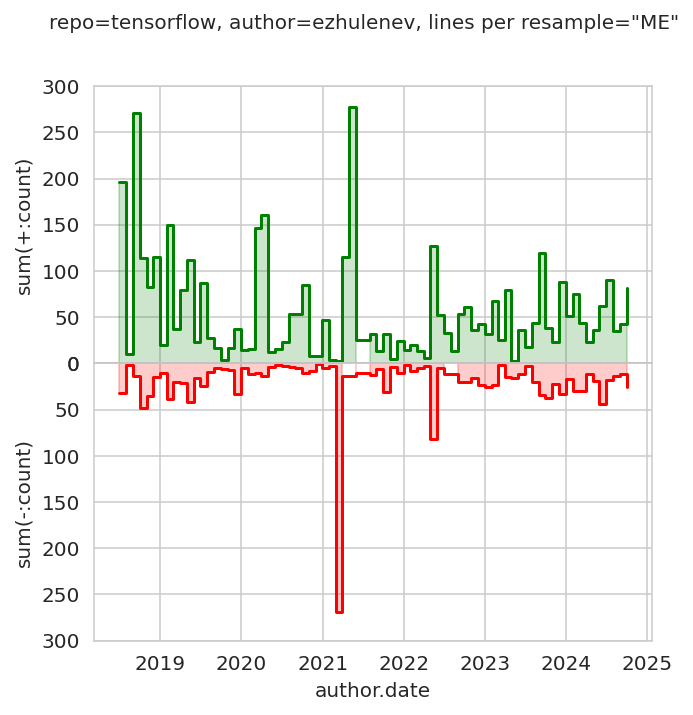

In [51]:
fig = plot_counts(tf_timeline_selected_resampled_df)
pn.pane.Matplotlib(fig, tight=True)

## Bihistogram of +/- lines (WIP)

In [52]:
def bihist(ax, dataset1, dataset2,
           dataset1_name='dataset1', dataset2_name='dataset2',
           dataset1_color='g', dataset2_color='r',
           bins=None):
    # Plot the first histogram
    ax.hist(dataset1, bins=bins, label=dataset1_name, color=dataset1_color)

    # Plot the second histogram
    # (notice the negative weights, which flip the histogram upside down)
    ax.hist(dataset2, weights=-np.ones_like(dataset2), bins=bins, label=dataset2_name, color=dataset2_color)
    ax.axhline(0, color="k", linewidth=0.2)
    ax.legend()

In [53]:
def plot_bihist(dataset1, dataset2,
                dataset1_name='dataset1', dataset2_name='dataset2',
                dataset1_color='g', dataset2_color='r',
                bin_width=5, max_value=100, figsize=None):
    sns.set_style("whitegrid")

    fig = Figure(figsize=figsize)
    ax = fig.subplots()

    bins = np.arange(0, max_value + bin_width, bin_width)

    bihist(ax,
           dataset1, dataset2,
           dataset1_name, dataset2_name,
           dataset1_color, dataset2_color,
           bins)
    
    return fig

In [54]:
'{pm}:count'.format(pm='+')

'+:count'

In [55]:
def bihist_pm_df(df, column_fmt='{pm}:count', color_plus='g', color_minus='r',
                 bin_width=5, max_value=100, figsize=None, title=None):
    added_counts   = df[column_fmt.format(pm='+')].values
    removed_counts = df[column_fmt.format(pm='-')].values

    # TODO: automatic max_value if None
    fig = plot_bihist(dataset1=added_counts, dataset2=removed_counts,
                      dataset1_name=column_fmt.format(pm='+'), dataset2_name=column_fmt.format(pm='-'),
                      dataset1_color=color_plus, dataset2_color=color_minus,
                      bin_width=bin_width, max_value=max_value, figsize=figsize)

    if title is not None:
        fig.suptitle(title, fontsize=10)
    
    return fig

Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
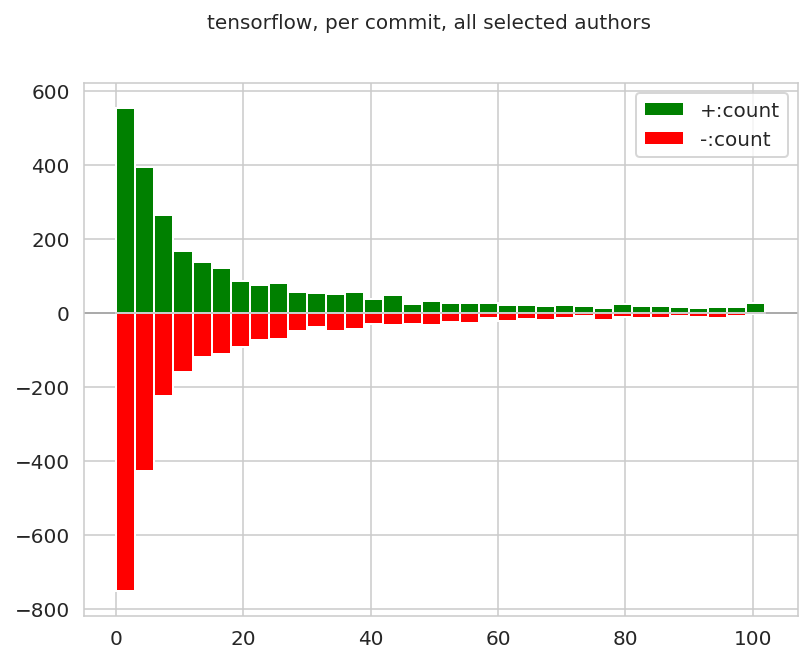

In [56]:
fig = bihist_pm_df(tf_timeline_df, bin_width=3, title='tensorflow, per commit, all selected authors')
pn.pane.Matplotlib(fig, tight=True)

In [57]:
tf_timeline_df[tf_timeline_df['bug_id'] == authors_widget.value][['+:count', '-:count']].values

array([[  3.,  nan],
       [ 22.,  nan],
       [ nan,   1.],
       ...,
       [ nan, 148.],
       [ 17.,  nan],
       [ 24.,   2.]])

In [58]:
vals = np.nan_to_num(tf_timeline_df[tf_timeline_df['bug_id'] == authors_widget.value][['+:count', '-:count']].values)
(max(vals.T[0]), max(vals.T[1]))

(np.float64(4865.0), np.float64(9050.0))

Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
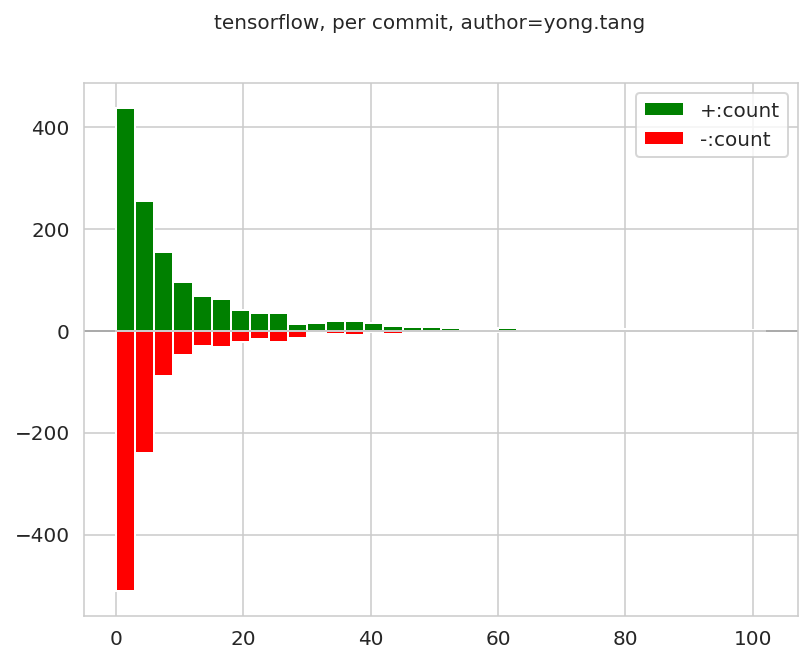

In [59]:
fig = bihist_pm_df(tf_timeline_df[tf_timeline_df['bug_id'] == authors_widget.value], bin_width=3, max_value=100,
                   title=f'tensorflow, per commit, author={authors_widget.value}')
pn.pane.Matplotlib(fig, tight=True)

In [60]:
agg_func_widget.value

'sum'

In [61]:
authors_widget.value

'yong.tang'

In [62]:
type(authors_widget.value)

str

In [63]:
resample_rule_widget.value

'ME'

In [64]:
tf_timeline_selected_resampled_df = resample_timeline(author=authors_widget.value, resample_rate=resample_rule_widget.value, agg_func='sum')

In [65]:
vals = tf_timeline_selected_resampled_df[['+:count', '-:count']].values
(max(vals.T[0]), max(vals.T[1]))

(np.float64(5491.0), np.float64(9369.0))

In [66]:
tf_timeline_selected_resampled_df[['+:count', '-:count']].head(5)

,+:count,-:count
author.date,,
2017-03-31 00:00:00+00:00,102.0,80.0
2017-04-30 00:00:00+00:00,16.0,7.0
2017-05-31 00:00:00+00:00,256.0,40.0
2017-06-30 00:00:00+00:00,1253.0,170.0
2017-07-31 00:00:00+00:00,191.0,48.0


In [67]:
tf_timeline_df[tf_timeline_df['bug_id'] == authors_widget.value][['author.date', '+:count', '-:count']].sort_values('author.date').head(10)

,author.date,+:count,-:count
812,2017-03-04 22:47:26+00:00,6.0,6.0
160,2017-03-05 19:27:24+00:00,4.0,4.0
754,2017-03-10 03:25:42+00:00,2.0,NaN
822,2017-03-18 13:12:44+00:00,6.0,6.0
1270,2017-03-22 22:44:28+00:00,42.0,NaN
887,2017-03-23 00:51:10+00:00,26.0,NaN
687,2017-03-25 21:03:33+00:00,7.0,55.0
1353,2017-03-26 20:01:55+00:00,9.0,9.0
962,2017-04-10 23:43:06+00:00,14.0,5.0
922,2017-04-29 15:38:24+00:00,2.0,2.0


Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
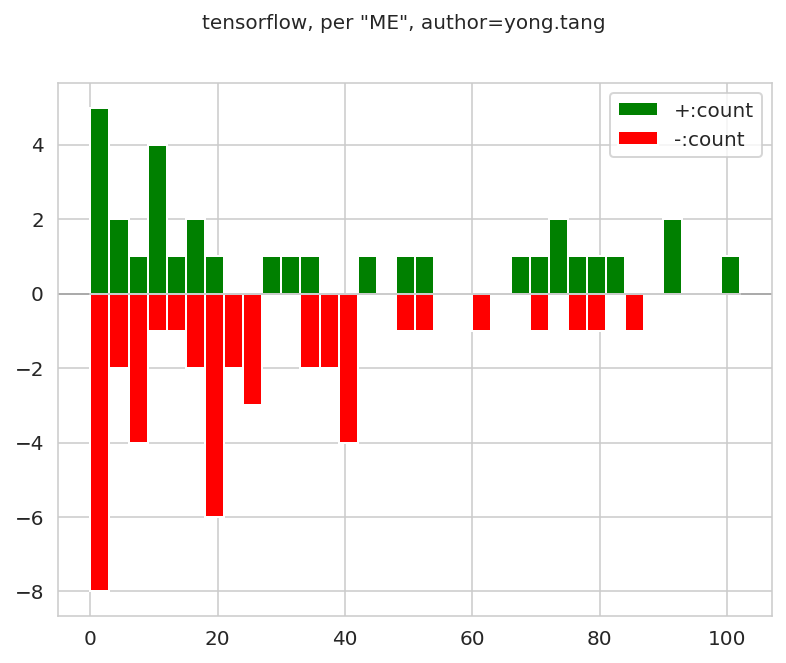

In [68]:
fig = bihist_pm_df(tf_timeline_selected_resampled_df, bin_width=3, 
                   title=f'tensorflow, per "{resample_rule_widget.value}", author={authors_widget.value}')
pn.pane.Matplotlib(fig, tight=True)

Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
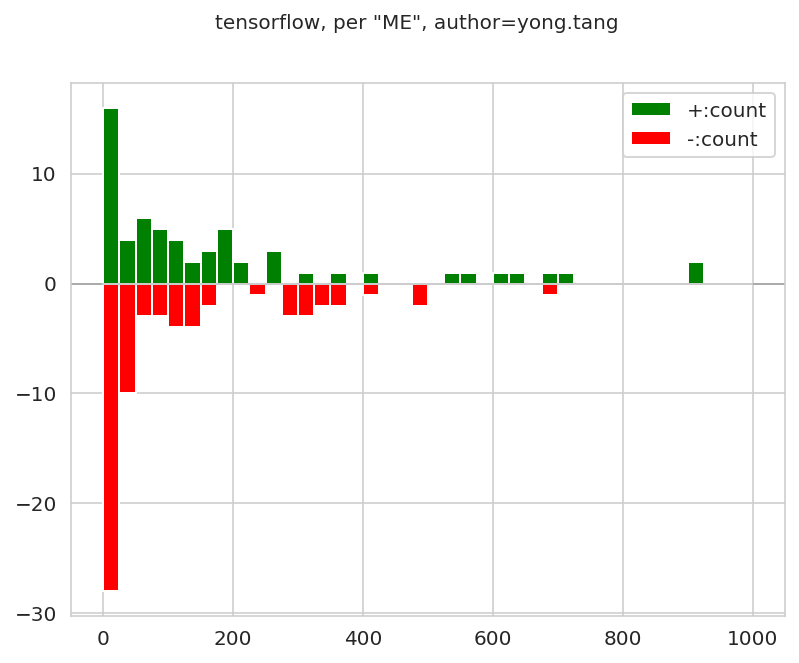

In [69]:
fig = bihist_pm_df(tf_timeline_selected_resampled_df, bin_width=25, max_value=1000,
                   title=f'tensorflow, per "{resample_rule_widget.value}", author={authors_widget.value}')
pn.pane.Matplotlib(fig, tight=True)

## Commits, resampled

In [70]:
def plot_commits(resampled_df: pd.DataFrame,
                 repo_desc: str = 'tensorflow', author_desc: str = 'ezhulenev',
                 resample_rate: str = 'ME',
                 figsize: tuple[float, float] = (5, 5)
):
    
    sns.set_style("whitegrid")

    fig = Figure(figsize=figsize)
    ax = fig.subplots()

    sns.lineplot(ax=ax, data=resampled_df, 
                 x='author.date', y='n_commits',
                 color='blue', drawstyle='steps-post')
    
    ax.fill_between(resampled_df.index, resampled_df['n_commits'],
                    alpha=0.2, color='blue', step='post')
    #ax.set_ylim(0, 120)
    ax.set_ylabel(f"commits")
    #ax.set_xlim(datetime.date(2017, 3, 31), datetime.date(2024, 9, 30))
    ax.set_title(f"author={author_desc}", fontsize=9)

    fig.suptitle(f'repo={repo_desc}, count of commits, resample="{resample_rate}"', fontsize=10)

    return fig

Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
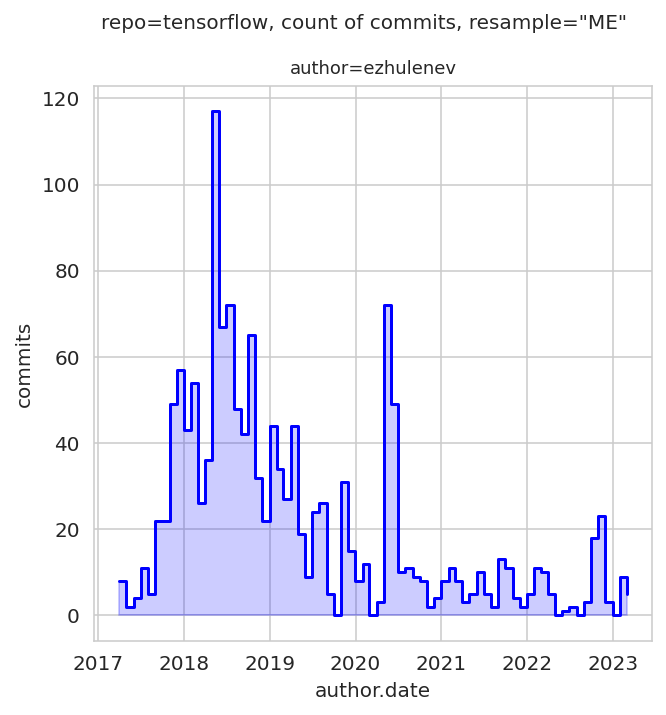

In [71]:
fig = plot_commits(tf_timeline_selected_resampled_df)
pn.pane.Matplotlib(fig, tight=True)

## Heatmap: time vs line type

In [72]:
from matplotlib.colors import LogNorm, Normalize

In [73]:
cols_plus_all  = [f"+:type.{type}" for type in ['code', 'documentation', 'test', 'other', 'data', 'markup', 'project']]
cols_minus_all = [f"-:type.{type}" for type in ['code', 'documentation', 'test', 'other', 'data', 'markup', 'project']]

In [74]:
def plot_heatmap(resampled_df: pd.DataFrame,
                 repo_desc: str = 'tensorflow', author_desc: str = 'ezhulenev',
                 resample_rate: str = 'ME', agg_func: str = 'sum',
                 figsize: tuple[float, float] = (16,3.3),
):
    for c in cols_plus_all:
        if c not in resampled_df.columns:
            resampled_df[c] = 0

    for c in cols_minus_all:
        if c not in resampled_df.columns:
            resampled_df[c] = 0
    
    sns.set_style("whitegrid")

    fig = Figure(figsize=figsize)
    axes = fig.subplots(nrows=2, ncols=1, sharex='col')

    sns.heatmap(resampled_df[cols_plus_all].transpose(),
                square=True, cmap='Greens', vmin=0, vmax=15000,
                xticklabels=False, norm=LogNorm(),
                ax=axes[1])
    axes[0].get_xaxis().set_visible(False)

    sns.heatmap(resampled_df[reversed(cols_minus_all)].transpose(),
                square=True, cmap='Reds', vmin=0, vmax=15000,
                xticklabels=False, norm=LogNorm(),
                ax=axes[0])

    fig.suptitle(f'repo={repo_desc}, author={author_desc}, resample="{resample_rate}", agg_func={agg_func!r}', fontsize=10)
    #fig.subplots_adjust(hspace=-0.2)

    return fig

Matplotlib(Figure, design=<class 'panel.theme.materi..., height=250, tight=True)
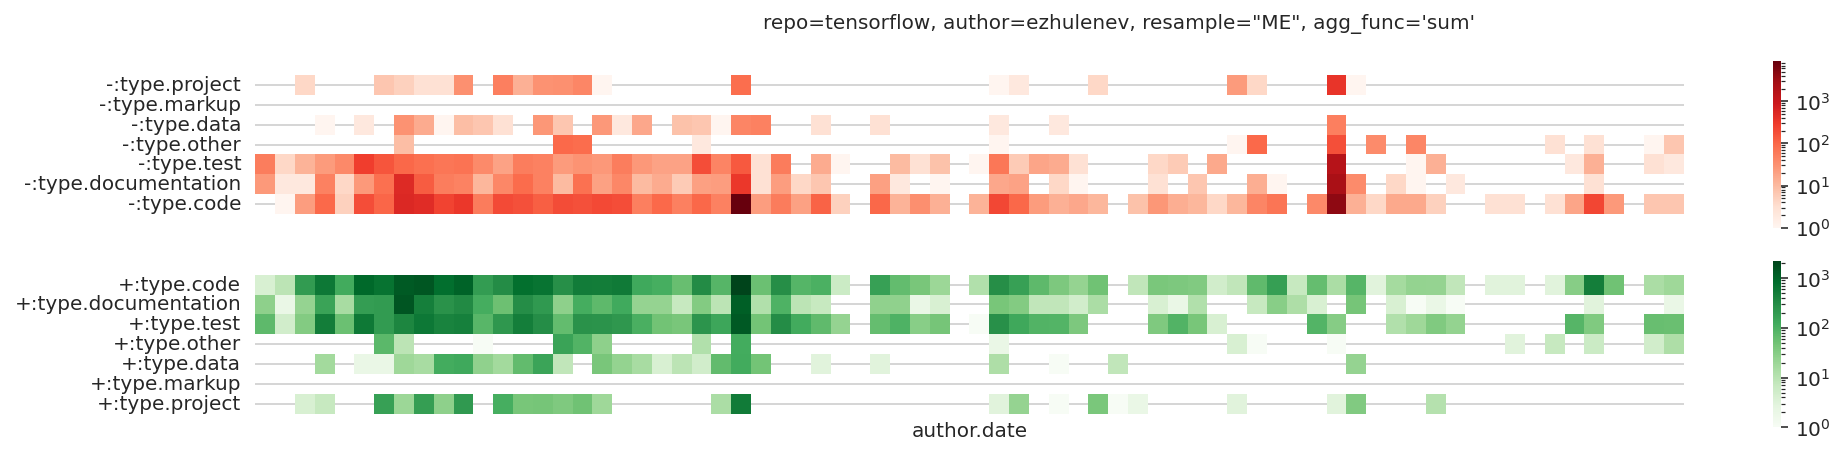

In [75]:
fig = plot_heatmap(tf_timeline_selected_resampled_df)
pn.pane.Matplotlib(fig, tight=True, height=250)

# Bind plots to widgets

In [76]:
def resample_and_plot_counts(repo: str = 'tensorflow', author: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum', figsize = (5,5)):
    resampled_df = resample_timeline(author, resample_rate=resample_rate, agg_func=agg_func)
    return plot_counts(resampled_df, repo_desc=repo, author_desc=author, resample_rate=resample_rate, agg_func=agg_func, figsize=figsize)

def resample_and_plot_commits(repo: str = 'tensorflow', author: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum', figsize = (5,5)):
    resampled_df = resample_timeline(author, resample_rate=resample_rate, agg_func=agg_func)
    return plot_commits(resampled_df, repo_desc=repo, author_desc=author, resample_rate=resample_rate, figsize=figsize)

def resample_and_plot_heatmap(repo: str = 'tensorflow', author: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum'):
    resampled_df = resample_timeline(author, resample_rate=resample_rate, agg_func=agg_func)
    return plot_heatmap(resampled_df, repo_desc=repo, author_desc=author, resample_rate=resample_rate, agg_func=agg_func)

+/- timeline

In [77]:
bound_pm_plot = pn.bind(
    resample_and_plot_counts, repo='tensorflow', author=authors_widget, resample_rate=resample_rule_widget, agg_func=agg_func_widget,
    figsize=(figsize_x_slider.value, figsize_y_slider.value),
)

Row(design=<class 'panel.theme.materi...)
    [0] Column(design=<class 'panel.theme.materi..., sizing_mode='fixed', width=300)
        [0] Select(design=<class 'panel.theme.materi..., name='author', options=['yong.tang', ...], value='yong.tang')
        [1] Select(design=<class 'panel.theme.materi..., name='frequency', options={'calendar day frequency':...}, value='ME')
        [2] Select(design=<class 'panel.theme.materi..., name='aggregation function', options=['sum', 'mean', ...], value='sum')
    [1] Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
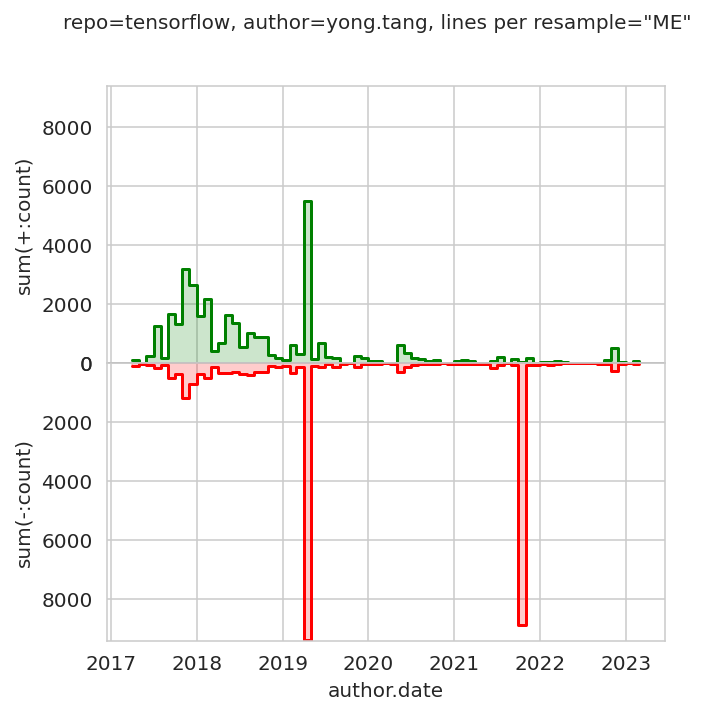

In [78]:
widgets = pn.Column(authors_widget, resample_rule_widget, agg_func_widget, sizing_mode="fixed", width=300)
pn.Row(widgets, pn.pane.Matplotlib(bound_pm_plot, tight=True))

In [79]:
bound_commits_plot = pn.bind(
    resample_and_plot_commits, repo='tensorflow', author=authors_widget, resample_rate=resample_rule_widget,
    figsize=(figsize_x_slider.value, figsize_y_slider.value),
)

Row(design=<class 'panel.theme.materi...)
    [0] Column(design=<class 'panel.theme.materi..., sizing_mode='fixed', width=300)
        [0] Select(design=<class 'panel.theme.materi..., name='author', options=['yong.tang', ...], value='yong.tang')
        [1] Select(design=<class 'panel.theme.materi..., name='frequency', options={'calendar day frequency':...}, value='ME')
    [1] Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
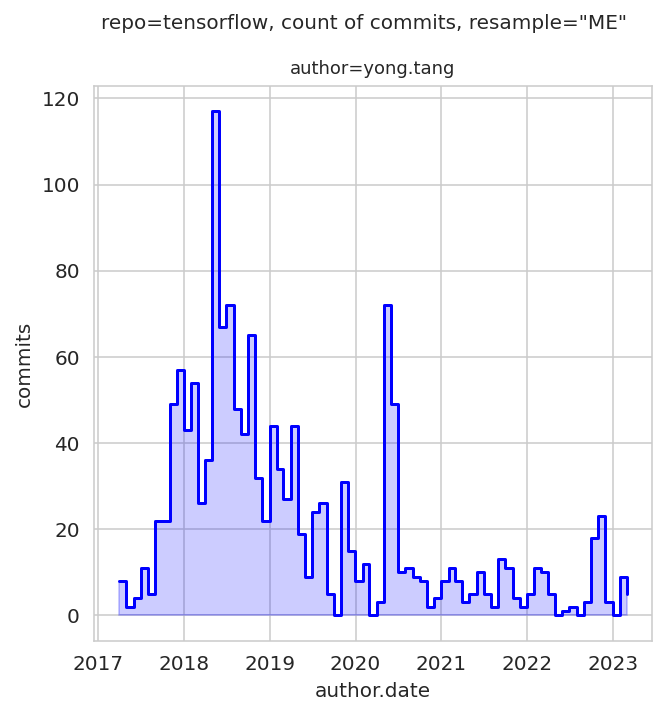

In [80]:
widgets = pn.Column(authors_widget, resample_rule_widget, sizing_mode="fixed", width=300)
pn.Row(widgets, pn.pane.Matplotlib(bound_commits_plot, tight=True))

In [81]:
bound_heatmap_plot = pn.bind(
    resample_and_plot_heatmap, repo='tensorflow', author=authors_widget, resample_rate='ME', agg_func=agg_func_widget,
)

Row(design=<class 'panel.theme.materi...)
    [0] Column(design=<class 'panel.theme.materi..., sizing_mode='fixed', width=300)
        [0] Select(design=<class 'panel.theme.materi..., name='author', options=['yong.tang', ...], value='yong.tang')
    [1] Matplotlib(Figure, design=<class 'panel.theme.materi..., height=250, sizing_mode='fixed', tight=True)
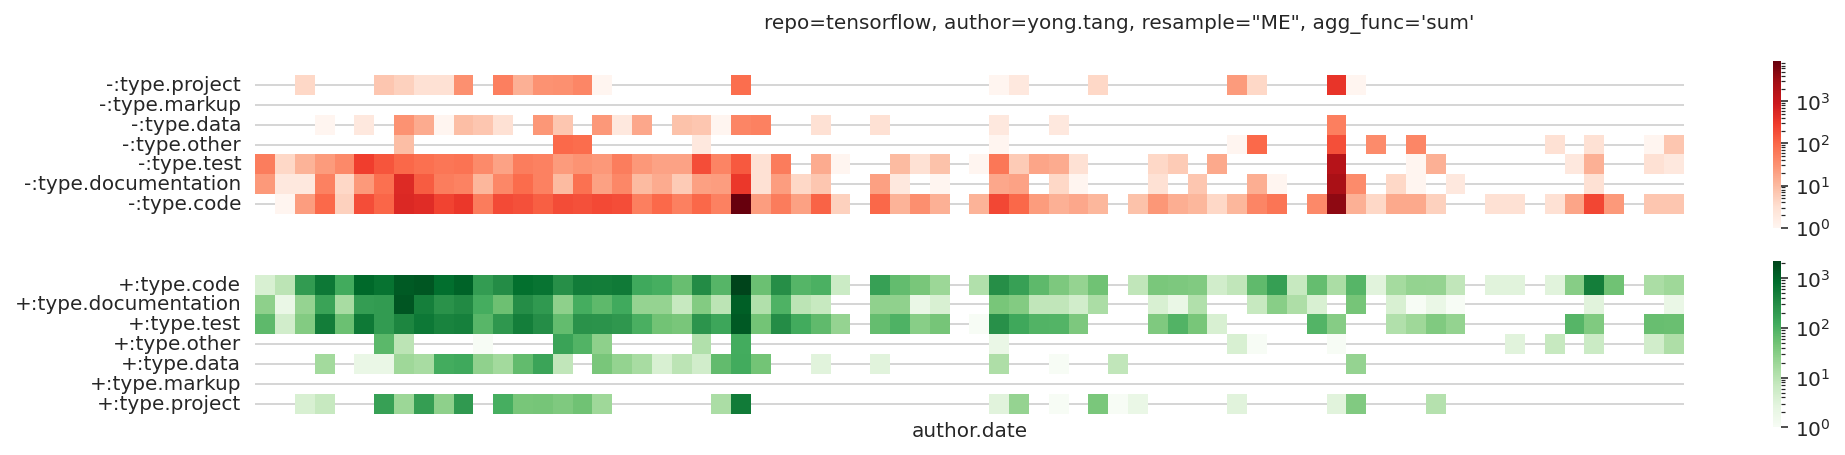

In [82]:
widgets = pn.Column(authors_widget, sizing_mode="fixed", width=300)
pn.Row(widgets, pn.pane.Matplotlib(bound_heatmap_plot, tight=True, sizing_mode="fixed", height=250))

In [111]:
@pn.cache
def tf_timeline_df_author(author: str = 'ezhulenev'):
    return tf_timeline_df[tf_timeline_df['bug_id'] == author]

@pn.cache
def hist_all_title(author: str = 'ezhulenev'):
    return f'tensorflow, per commit, author={author}' 


bound_timeline_df_author = pn.bind(
    tf_timeline_df_author, authors_widget,
)

bound_hist_all_title = pn.bind(
    hist_all_title, authors_widget,
)


bound_hist_all_plot = pn.bind(
    bihist_pm_df,
    bound_timeline_df_author,
    bin_width=bin_width_widget.param.value_throttled, max_value=max_value_widget.param.value_throttled,
    title=bound_hist_all_title,
)

Row(design=<class 'panel.theme.materi...)
    [0] Column(design=<class 'panel.theme.materi..., sizing_mode='fixed', width=300)
        [0] Select(design=<class 'panel.theme.materi..., name='author', options=['yong.tang', ...], value='yong.tang')
        [1] WidgetBox(design=<class 'panel.theme.materi...)
            [0] Markdown(str, design=<class 'panel.theme.materi...)
            [1] EditableIntSlider(design=<class 'panel.theme.materi..., end=25, fixed_start=1, margin=(-5, 10), name='bin width', start=1, value=6, width=300)
            [2] EditableIntSlider(design=<class 'panel.theme.materi..., end=500, fixed_start=1, margin=(-2, 10), name='max value', start=10, step=5, value=100, width=300)
    [1] Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
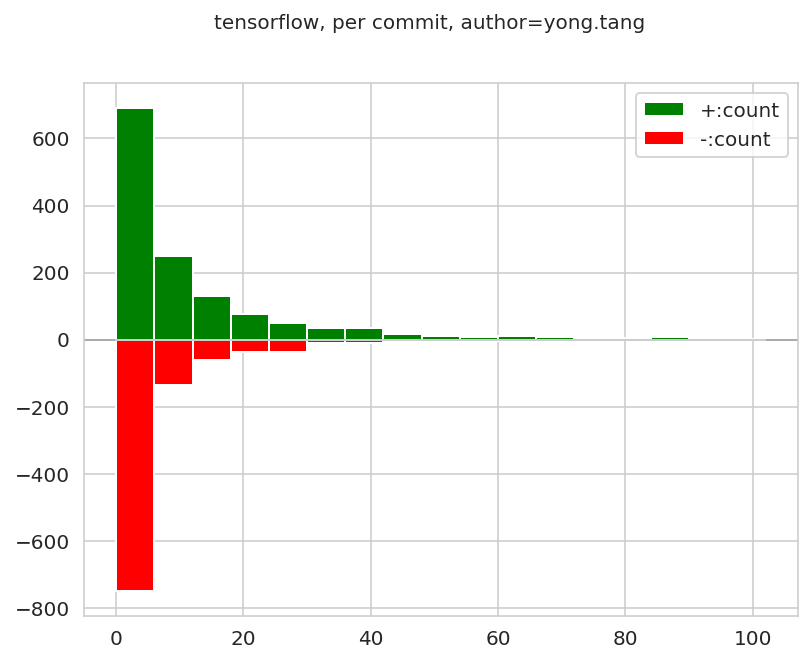

In [114]:
widgets = pn.Column(authors_widget, hist_widget, sizing_mode="fixed", width=300)
pn.Row(widgets, pn.pane.Matplotlib(bound_hist_all_plot, tight=True))

# Serving the Notebook

In [115]:
pn.template.MaterialTemplate(
    site="diffannotator",
    title="Examining Timeline",
    #sidebar_width=sidebar_width.rx(),  # does not work!
    sidebar_width=350,
    sidebar=[
        repos_widget,  # disabled, and UNBOUND!
        authors_widget,
        #authors_radio_box,
        resample_rule_widget,
        agg_func_widget,
        hist_widget,
        pn.layout.VSpacer(),
        #pn.Spacer(height=100),
        figsize_widget,
        plot_sizing_mode,
        plot_width,
        plot_format,
    ],
    main=[
        pn.FlexBox(
            pn.Card(pn.pane.Matplotlib(bound_pm_plot, 
                                       tight=True,
                                       format=plot_format.rx(),
                                       fixed_aspect=False,
                                       sizing_mode='fixed',
                                       width=plot_width.rx(),
                                       height=plot_width.rx(),
                                       styles={
                                           "margin-left":  "auto",
                                           "margin-right": "auto",
                                       },
                   ),
                    header="line counts"),
            pn.Card(pn.pane.Matplotlib(bound_commits_plot,
                                       tight=True,
                                       format=plot_format.rx(),
                                       sizing_mode='fixed',
                                       width=plot_width.rx(),
                                       height=plot_width.rx(),
                                       # NOTE: trying the trick below does not work, for some reason
                                       #sizing_mode=plot_sizing_mode.rx(),
                                       #width=100 if plot_sizing_mode.rx() == 'fixed' else None),  # does not work!
                                       styles={
                                           "margin-left":  "auto",
                                           "margin-right": "auto",
                                       },
                   ),
                    header="commit counts"),
            pn.Card(pn.pane.Matplotlib(bound_hist_all_plot,
                                       tight=True,
                                       format=plot_format.rx(),
                                       sizing_mode='fixed',
                                       width=plot_width.rx(),
                                       height=plot_width.rx(),
                                       # NOTE: trying the trick below does not work, for some reason
                                       #sizing_mode=plot_sizing_mode.rx(),
                                       #width=100 if plot_sizing_mode.rx() == 'fixed' else None),  # does not work!
                                       styles={
                                           "margin-left":  "auto",
                                           "margin-right": "auto",
                                       },
                   ),
                    header="histogram of -/+ counts per commit"),
            pn.Card(pn.pane.Matplotlib(bound_heatmap_plot,
                                       tight=True,
                                       format=plot_format.rx(),
                                       sizing_mode='fixed',
                                       width =plot_width.rx()*2,
                                       height=plot_width.rx()*1,
                                       styles={
                                           "margin-left":  "auto",
                                           "margin-right": "auto",
                                       },
                   ),
                    header="heatmap line-types"),
        )
    ],
).servable(); # The ; is needed in the notebook to not display the template. Its not needed in a script